In [52]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pymc as pm
import multiprocessing
import arviz as az
import warnings

# --- Reproducibility setup ---
SEED = 1

np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
pm.set_data = getattr(pm, "set_data", lambda *args, **kwargs: None)

# --- Warning filters ---
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Preprocessing

## Data loading

In [53]:
## Import data
data_path = "../data/raw/higgs-challenge.csv.gz"
df = pd.read_csv(data_path, compression="gzip")
# set EventId as index
df.set_index("EventId", inplace=True)

## Visualization of raw data

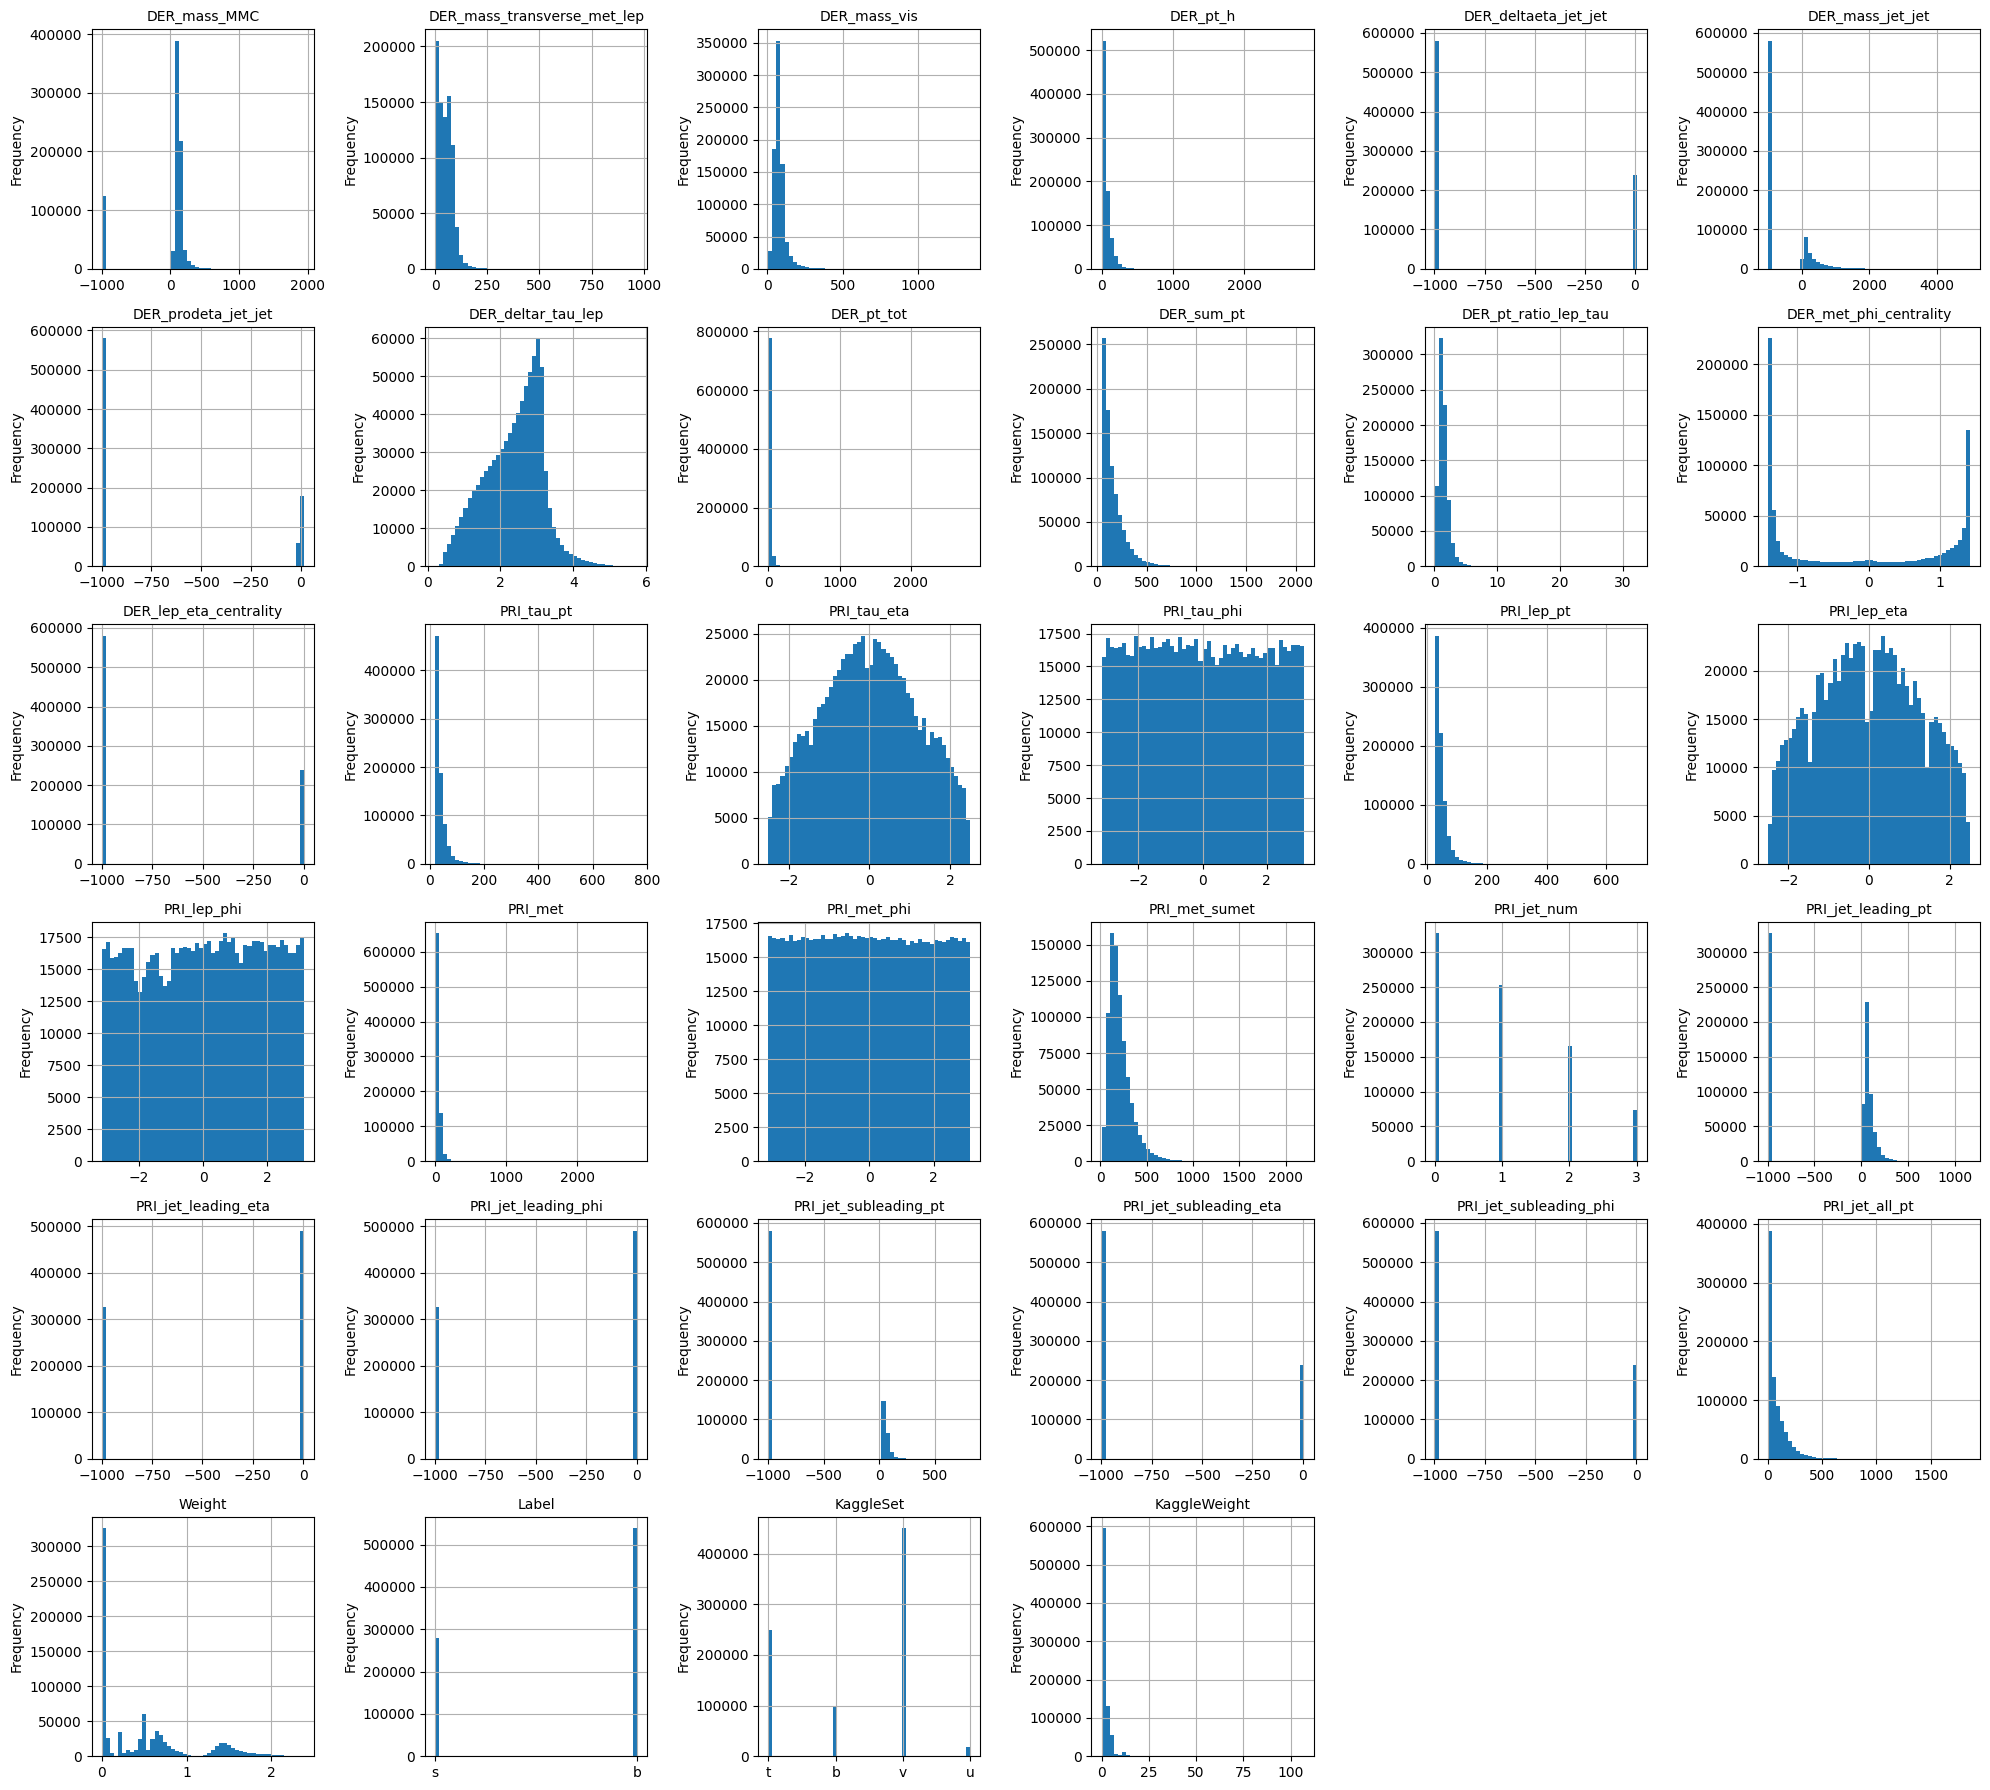

In [54]:
plt.figure(figsize=(20, 18))

for i, column in enumerate(df.columns):
    plt.subplot(6, 6, i + 1)
    df[column].hist(bins=50)
    plt.title(column, fontsize=10)
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("../plots/histogram_nonclean.png", dpi=300)
plt.show()

## Treatment of Missing Values
- Missing data can bias parameter estimation and weaken predictive reliability.
- Since the dataset is large and missingness is minimal, we apply *listwise deletion* (drop rows with NaN). This preserves consistency while simplifying the model.
- In Bayesian modeling, missing values could alternatively be imputed as latent variables, but given the data size, deletion is more practical here.

In [55]:
missing_values = df.isnull().sum()
missing_values_percentage = (missing_values / len(df)) * 100
# Print columns with missing values and their percentages
for col, perc in missing_values_percentage.items():
    if perc > 0:
        print(f"Column: {col}, Missing Values: {perc:.2f}%")
# Drop rows with any missing values
df = df.dropna()

## Treatment of Incoherent or Incorrect Values
- We realized that there were many -999 values for many variables. The missing values in columns with 'jet' in their name are from particles with 'PRI_jet_num' equal to 0 or 1, so instead of dropping the rows we will drop the columns. They only give information about particles with 2 or 3 jets and otherwise we would miss 71% of our data. 
- There is another column, DER_mass_MCC with 15.23% of missing values. In this case we prefer to delete those rows since the variable is important and we don't want to lose it, and 15.23% of the data is an acceptable price to keep it.

In [56]:
# A value is missing if it is equal to -999.0
df.replace(-999.0, np.nan, inplace=True)
# Count number of missing values per column
missing_values = df.isnull().sum()
missing_values_percentage = (missing_values / len(df)) * 100
# Print columns with missing values and their percentages
for col, perc in missing_values_percentage.items():
    if perc > 0:
        print(f"Column: {col}, Missing Values: {perc:.2f}%")

Column: DER_mass_MMC, Missing Values: 15.23%
Column: DER_deltaeta_jet_jet, Missing Values: 70.91%
Column: DER_mass_jet_jet, Missing Values: 70.91%
Column: DER_prodeta_jet_jet, Missing Values: 70.91%
Column: DER_lep_eta_centrality, Missing Values: 70.91%
Column: PRI_jet_leading_pt, Missing Values: 40.01%
Column: PRI_jet_leading_eta, Missing Values: 40.01%
Column: PRI_jet_leading_phi, Missing Values: 40.01%
Column: PRI_jet_subleading_pt, Missing Values: 70.91%
Column: PRI_jet_subleading_eta, Missing Values: 70.91%
Column: PRI_jet_subleading_phi, Missing Values: 70.91%


In [57]:
# Drop columns with NA except DER_mass_MMC
cols_to_drop = [col for col in missing_values.index if missing_values[col] > 0 and col != "DER_mass_MMC"]
df.drop(columns=cols_to_drop, inplace=True)

# Drop rows with any missing values in DER_mass_MMC
df.dropna(subset=["DER_mass_MMC"], inplace=True)
df = df.dropna()
df.reset_index(drop=True, inplace=True)

## Elimination of Irrelevant Variables
- Two variables related to the kaggle competition that used this dataset are irrelevant to the model.
- Weight is separated from features

In [58]:
# Drop uninformative columns
weights = df["Weight"]
df = df.drop(["KaggleSet", "KaggleWeight", "Weight"], axis=1)


## Elimination of Redundant Variables
- Highly correlated variables can cause multicollinearity and slow down Bayesian sampling.
- We detect features with |correlation| > 0.85 and drop one of each pair.
- This approximates a decorrelated feature space while preserving interpretability.

In [59]:
corr_matrix = df.drop(columns=["Label"]).corr().abs()

# Keep only the upper triangle of the correlation matrix (to avoid duplicates)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns to drop
to_drop = []
drop_reasons = []

for column in upper.columns:
    # Find correlations above threshold
    high_corr = upper[column][upper[column] > 0.85]
    if not high_corr.empty:
        to_drop.append(column)
        for correlated_col, corr_value in high_corr.items():
            drop_reasons.append((column, correlated_col, corr_value))

# Drop the columns
df.drop(columns=to_drop, inplace=True)

# Print results
print(f"Dropped {len(to_drop)} highly correlated (redundant) features:\n")
for col, corr_col, corr_val in drop_reasons:
    print(f" - Dropped '{col}' (correlated with '{corr_col}' at {corr_val:.2f})")

Dropped 3 highly correlated (redundant) features:

 - Dropped 'DER_mass_vis' (correlated with 'DER_mass_MMC' at 0.91)
 - Dropped 'PRI_met_sumet' (correlated with 'DER_sum_pt' at 0.91)
 - Dropped 'PRI_jet_all_pt' (correlated with 'DER_sum_pt' at 0.97)
 - Dropped 'PRI_jet_all_pt' (correlated with 'PRI_met_sumet' at 0.89)


## Coding of Non-Continuous Variables
- The categorical variable `PRI_jet_num` represents the number of jets (0, 1, 2 or 3).
- Even though it is technically discrete, its numeric values have an inherent ordering. Treating PRI_jet_num as numeric implicitly assumes the log-odds of being signal changes monotonically with jet count. For this variable, such a monotonic relationship is theoretically justified: in the Higgs signal process, certain jet multiplicities are systematically more (or less) likely to occur. If the actual relationship is nonlinear, it can be captured via Bayesian priors that allow smooth deviations.

## Normalization of Variables
- Standardization (zero mean, unit variance) ensures comparable scales for all features.
- In Bayesian logistic regression, this stabilizes posterior sampling since priors like Normal(0, 2.5) assume standardized covariates.
- It also mitigates numerical instability in matrix operations during MCMC.

In [60]:
scaler = StandardScaler()
num_features = df.select_dtypes(include=[np.number]).columns
df[num_features] = scaler.fit_transform(df[num_features])
print("Standardized all numeric features.")

Standardized all numeric features.


# Visualize data distributions

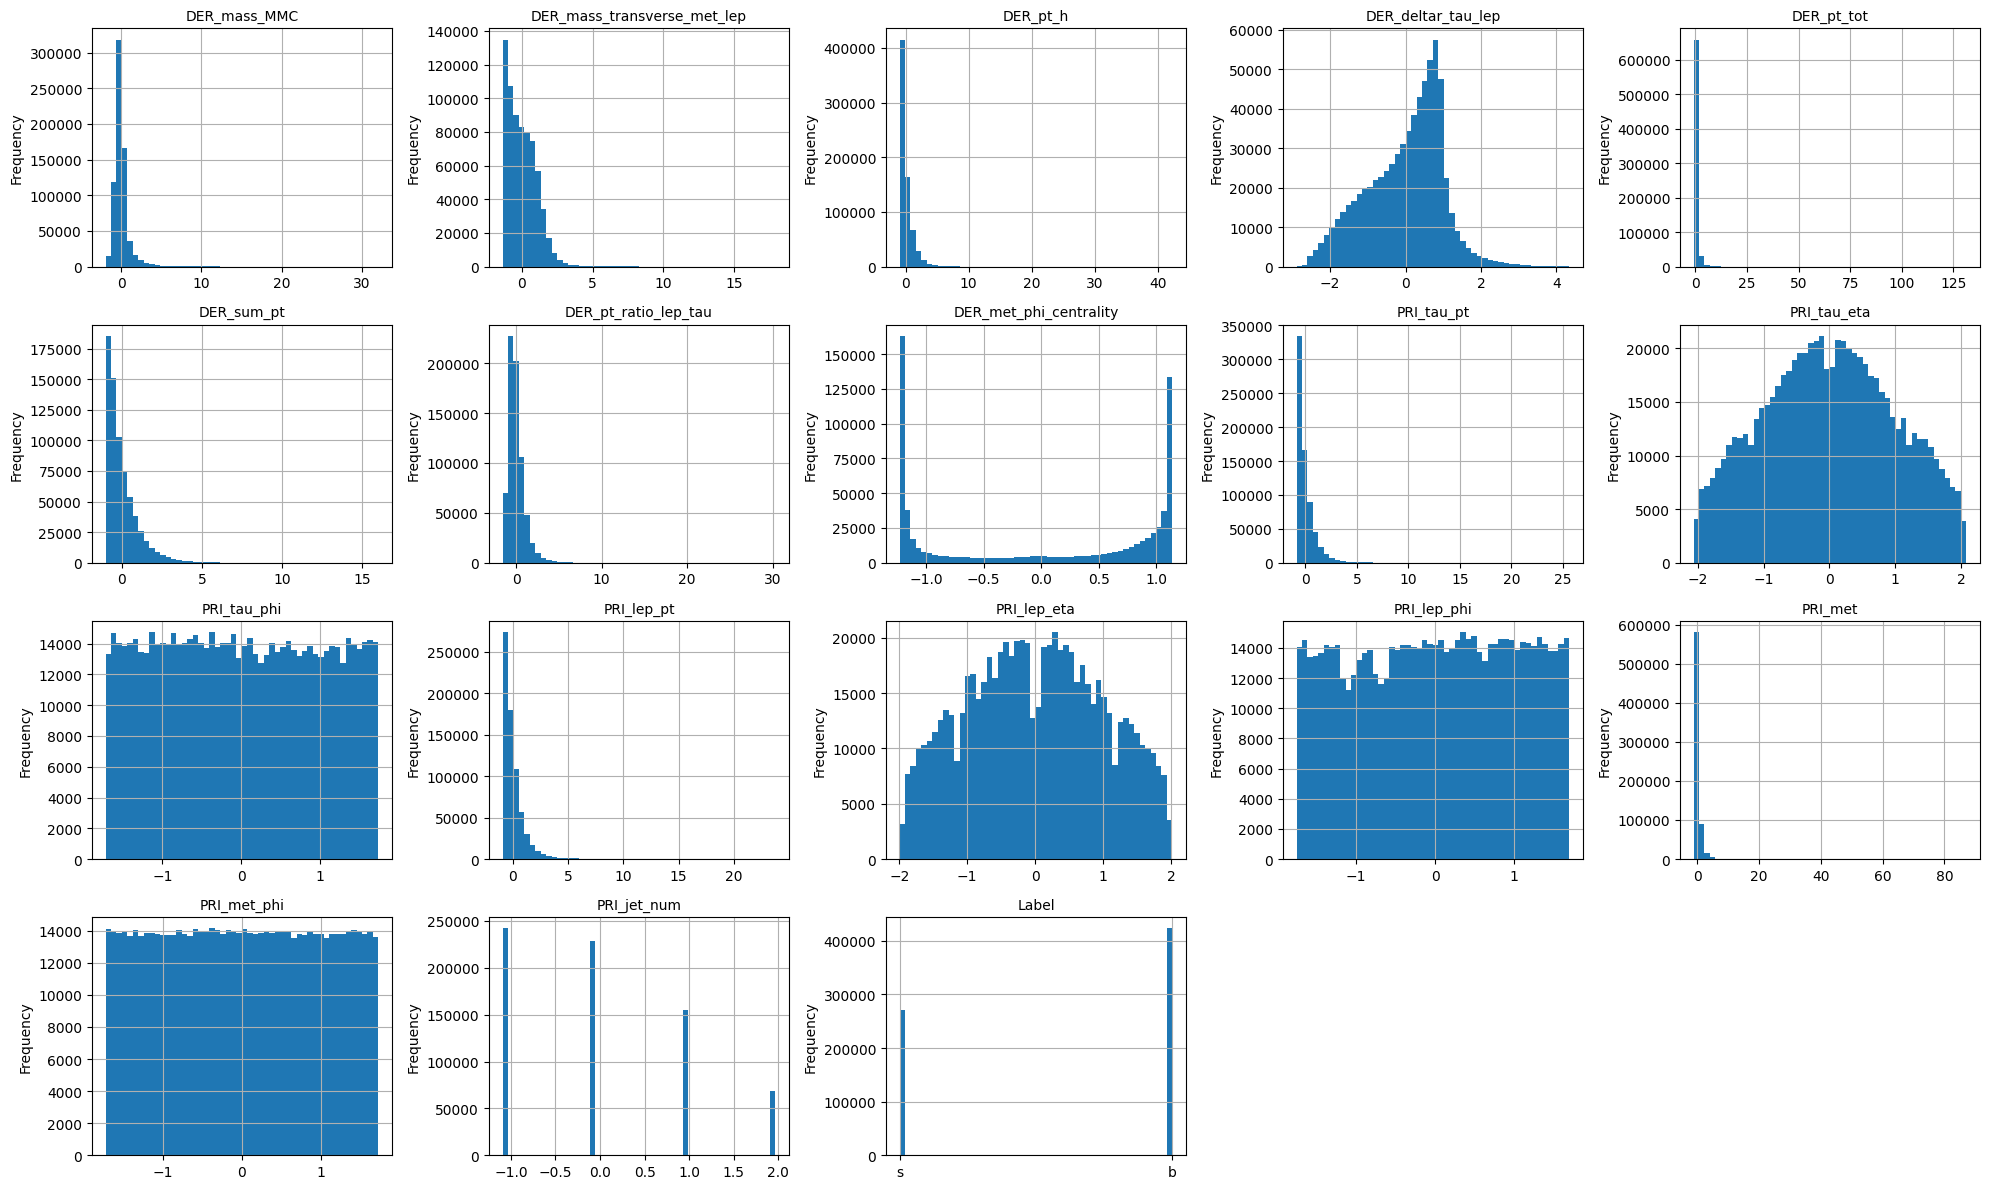

In [61]:
plt.figure(figsize=(20, 12))

for i, column in enumerate(df.columns):
    plt.subplot(4, 5, i + 1)
    df[column].hist(bins=50)
    plt.title(column, fontsize=10)
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("../plots/histogram.png", dpi=300)
plt.show()

Text(0, 0.5, 'Frequency')

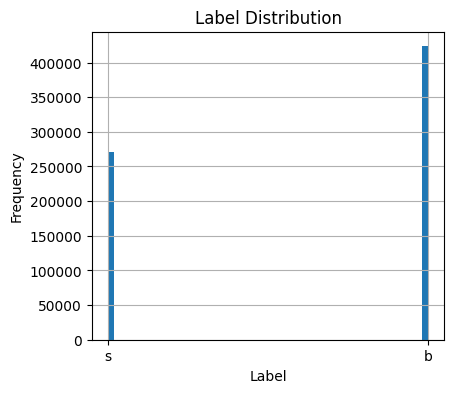

In [62]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df["Label"].hist(bins=50)
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")

In [63]:
#Save dataset and weights
df.to_csv("../data/processed/df_preprocessed.csv")
weights.to_csv("../data/processed/weights.csv")

# Split into training and test sets

In [71]:
#Load preprocessed data
df = pd.read_csv("../data/processed/df_preprocessed.csv", index_col=0)
weights =  pd.read_csv("../data/processed/weights.csv", index_col=0)
df['Weight'] = weights

data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)
weights_train = data_train["Weight"]
weights_test = data_test["Weight"]
X_train = data_train.drop(["Weight", "Label"], axis=1)
X_test = data_test.drop(["Weight", "Label"], axis=1)
y_train = data_train["Label"]
y_test = data_test["Label"]

# Bayesian logistic regression model

**Model specifics and theoretical justification**

We model $y_i \sim \text{Bernoulli}(\sigma(X_i \beta + \alpha))$ where:

- $X_i$ are standardized features.
- Priors: $\beta_j \sim \mathcal{N}(0,\, 2.5)$.  
  *Rationale:* weakly informative prior recommended for logistic regression (reduces extreme posterior wandering, regularizes coefficients).
- Intercept: $\alpha \sim \mathcal{N}(0,\, 5)$.
- We use NUTS for sampling; inference produces posterior samples for every coefficient.


In [ ]:
# If dataset is huge, MCMC may be slow. We'll sample a reasonable subset, preserving class balance.
max_train_samples = 100000
feature_names = list(X_train.columns)

if X_train.shape[0] > max_train_samples:
    # stratified sampling
    train_df = X_train.copy()
    train_df["y"] = y_train
    train_small = train_df.groupby("y").sample(n=int(max_train_samples / 2), random_state=42)
    X_bayes = train_small[feature_names].values
    y_bayes = train_small["y"].values
    print("Using subsample for MCMC:", X_bayes.shape)
else:
    X_bayes = X_train.values
    y_bayes = y_train.values
    print("Using full training set for MCMC:", X_bayes.shape)

Using subsample for MCMC: (1000, 17)


In [74]:
# Build and run PyMC model (computationaly expensive, just load the results from the cell below)
y_bayes_num = np.where(y_bayes == "s", 1, 0).astype(int)
n_features = X_train.shape[1]

with pm.Model() as logistic_model:
    # Priors
    alpha = pm.Normal("alpha", mu=0.0, sigma=5.0)
    beta = pm.Normal("beta", mu=0.0, sigma=2.5, shape=n_features)

    # Linear predictor (dot product)
    # convert X to shared variable for possible re-use -> but simple approach now
    mu = alpha + pm.math.dot(X_bayes, beta)

    # Likelihood
    theta = pm.math.sigmoid(mu)
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y_bayes_num)

    # Sample with NUTS
    trace = pm.sample(
        draws=2000,
        tune=1500,
        chains=2,
        progressbar=True,
        cores=multiprocessing.cpu_count(),
        target_accept=0.9,
        return_inferencedata=True,
    )

    # Save the model
    az.to_netcdf(trace, "models/bayesian_logreg_trace.nc")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Output()

Sampling 2 chains for 1_500 tune and 1_565 draw iterations (3_000 + 3_130 draws total) took 110 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = 'c:\Users\Daniel\Desktop\AML\Labs\MDS-AML-HiggsBosonATLAS\notebooks\models\bayesian_logreg_trace.nc', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [76]:
# Load the model
trace = az.from_netcdf("../models/bayesian_logreg_trace.nc")

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.439,0.012,0.416,0.463,0.0,0.0,2738.0,2809.0,1.0
beta[0],-0.862,0.018,-0.894,-0.826,0.0,0.0,2540.0,2684.0,1.0
beta[1],-0.675,0.009,-0.695,-0.657,0.0,0.0,5619.0,2170.0,1.0
beta[2],0.255,0.013,0.229,0.282,0.0,0.0,2648.0,3042.0,1.0
beta[3],1.093,0.018,1.056,1.128,0.0,0.0,2548.0,2957.0,1.0
beta[4],-0.225,0.008,-0.241,-0.210,0.0,0.0,5080.0,2918.0,1.0
beta[5],-0.278,0.017,-0.312,-0.245,0.0,0.0,2671.0,2731.0,1.0
beta[6],0.300,0.017,0.265,0.332,0.0,0.0,2207.0,2512.0,1.0
beta[7],0.324,0.010,0.304,0.343,0.0,0.0,4150.0,3182.0,1.0
beta[8],1.420,0.020,1.383,1.461,0.0,0.0,1938.0,2422.0,1.0


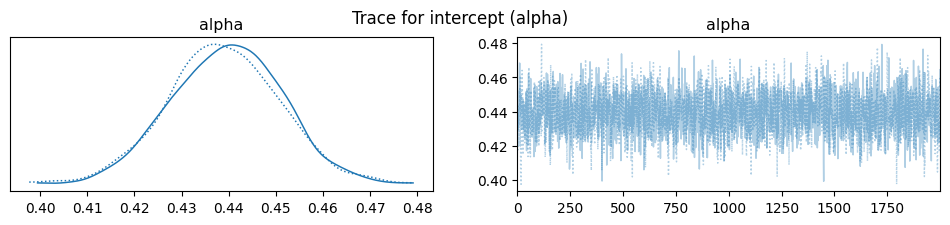

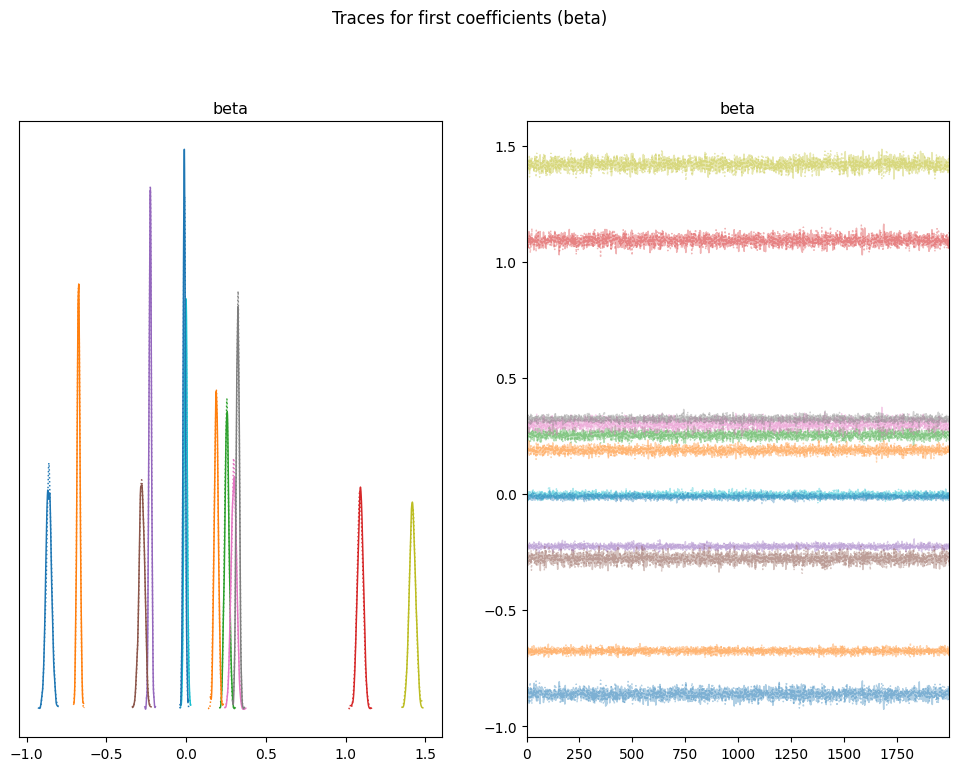

In [77]:
# Diagnostics: traceplot and posterior summary
az.plot_trace(trace, var_names=["alpha"])
plt.suptitle("Trace for intercept (alpha)", y=1.02)

# Plot several coefficient traces (first 12 coefficients for readability)
subset_beta_idx = list(range(min(12, n_features)))
az.plot_trace(trace, var_names=["beta"], coords={"beta_dim_0": subset_beta_idx}, figsize=(12, 8))
plt.suptitle("Traces for first coefficients (beta)", y=1.02)

# Posterior summary numeric
summary_df = az.summary(trace, var_names=["alpha", "beta"], hdi_prob=0.95)
display(summary_df)

## Posterior predictive checks & predictive performance

We approximate predictive probabilities on the test set using posterior samples:
- use posterior samples of `alpha` and `beta` to compute predictive probabilities for each test point (posterior predictive mean)
- compute ROC AUC from posterior predictive mean
- compare with baseline logistic regression

In [79]:
# Posterior predictive probabilities on test set (approximate with Monte Carlo)
# Get posterior samples arrays
posterior = trace.posterior
beta_samples = posterior["beta"].stack(sample=("chain", "draw")).values
alpha_samples = posterior["alpha"].stack(sample=("chain", "draw")).values.flatten()
beta_all = beta_samples
alpha_all = alpha_samples

# Use all posterior samples for predictions (may be large)
n_post_samples = beta_all.shape[1]
print("Posterior draws available:", n_post_samples)

# Convert X_test to numpy
X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test


# compute p(y=1 | x, posterior) approximated by sigmoid(alpha_s + x @ beta_s) averaged over posterior draws
# we vectorize in chunks to avoid memory spikes
def posterior_predictive_proba(X, alpha_samps, beta_samps, chunk=1000):
    n_samples = beta_samps.shape[1]
    probs_accum = np.zeros((X.shape[0],))
    # iterate over posterior draws in chunks
    for i in range(0, n_samples, chunk):
        b = beta_samps[:, i : i + chunk]
        a = alpha_samps[i : i + chunk]
        # compute linear predictors for chunk: X @ b
        lin = X @ b
        lin = lin + a  # broadcasts
        probs_chunk = 1 / (1 + np.exp(-lin))
        probs_accum += probs_chunk.mean(axis=1) * (chunk / n_samples)
    return probs_accum


# safe chunking: choose chunk size so we exactly weight average
posterior_mean_proba = posterior_predictive_proba(X_test_np, alpha_all, beta_all, chunk=200)

auc_bayes = roc_auc_score(y_test, posterior_mean_proba)
print(f"Bayesian logistic (posterior mean predictive) AUC: {auc_bayes:.4f}")

# Threshold posterior mean probability at 0.5
y_pred_bayes = (posterior_mean_proba >= 0.5).astype(int)

# Ensure true labels
y_test_num = np.where(y_test == "s", 1, 0).astype(int)

# Accuracy
acc_bayes = accuracy_score(y_test_num, y_pred_bayes)
print(f"Bayesian Logistic Regression Accuracy: {acc_bayes:.4f}")

# Classification report
print("Bayesian Logistic Regression Classification Report:")
print(classification_report(y_test_num, y_pred_bayes, target_names=["b", "s"]))

Posterior draws available: 4000
Bayesian logistic (posterior mean predictive) AUC: 0.7655
Bayesian Logistic Regression Accuracy: 0.6603
Bayesian Logistic Regression Classification Report:
              precision    recall  f1-score   support

           b       0.85      0.54      0.66     84515
           s       0.54      0.85      0.66     54213

    accuracy                           0.66    138728
   macro avg       0.70      0.69      0.66    138728
weighted avg       0.73      0.66      0.66    138728



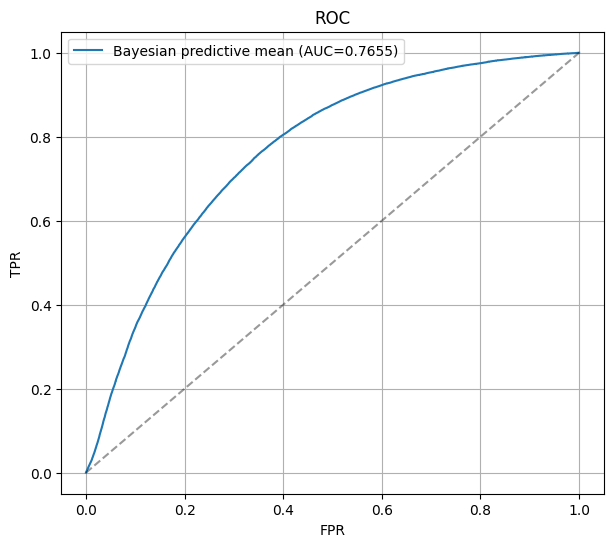

In [80]:
# ROC curve
fpr_b, tpr_b, _ = roc_curve(y_test, posterior_mean_proba, pos_label="s")

plt.figure(figsize=(7, 6))
plt.plot(fpr_b, tpr_b, label=f"Bayesian predictive mean (AUC={auc_bayes:.4f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()
plt.grid(True)